In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer import Predictive

from utils import *

In [2]:
def model3(game_info, obs=None):
    """
    Inputs:
        obs: obs: A 1D tensor of observed data. The length should be equal to the number of games played.
             Represents the outcome of a game in the eyes of coach 1, i.e. coach 1 wins: obs = 1, coach 2 wins: obs = -1.
        ids1: A 1D tensor of the same length as obs. Contains the index of the first coach in each game.
        ids2: A 1D tensor of the same length as obs. Contains the index of the second coach in each game.
        num_coaches: The number of coaches in the dataset.

    Output: A 1D tensor of the same length as "obs". Represents a sample from difference in performance between the two coaches.
    """

    # Extract the data
    ids1 = game_info['coach1_id']
    ids2 = game_info['coach2_id']
    num_coaches = game_info['num_coaches']

    hyper_sigma = 1/8
    
    coach_mu_skill = 0
    coach_sigma_skill = 1

    # Sample skills for each coach using a plate for coaches
    with pyro.plate('coaches', num_coaches):
        coach_skills = pyro.sample("coach_skills", dist.Normal(coach_mu_skill, coach_sigma_skill))
    
    with pyro.plate('matches', obs.shape[0]):
        # Gather the skills for the competing coaches in each match
        coach1_skills = coach_skills[ids1]
        coach2_skills = coach_skills[ids2]

        # Sample performances for the coaches in each match
        coach1_perf = pyro.sample('coach1_perf', dist.Normal(coach1_skills, hyper_sigma))
        coach2_perf = pyro.sample('coach2_perf', dist.Normal(coach2_skills, hyper_sigma))

        # Compute the performance difference
        perf_diff = coach1_perf - coach2_perf

        # Sample the observed outcomes
        y = pyro.sample("y_coach1_win", dist.Normal(perf_diff, hyper_sigma), obs=obs)

    return y

In [3]:
# Fake data to see if this model gets same results as previous model
num_games = 12
obs = torch.ones(num_games)
id1 = torch.zeros(len(obs)).long()
id2 = torch.ones(len(obs)).long()
num_coaches = 2

game_info = {'coach1_id': id1, 'coach2_id': id2, 'num_coaches': num_coaches}

run_inference(model3, game_info, obs)

Step 0 : loss = 445.65476191043854
Step 100 : loss = 1.9458436965942383
Step 200 : loss = -0.6511101722717285
Step 300 : loss = 1.5958060026168823
Step 400 : loss = 1.370448112487793
Step 500 : loss = 2.4354248046875
Step 600 : loss = 3.239753246307373
Step 700 : loss = 0.1851048469543457
Step 800 : loss = -0.4355807304382324
Step 900 : loss = 3.032480478286743
Step 1000 : loss = 3.430609941482544
Step 1100 : loss = -2.9441921710968018
Step 1200 : loss = 0.30243635177612305
Step 1300 : loss = 4.5844645500183105
Step 1400 : loss = 3.2632793188095093
Step 1500 : loss = 0.4412038326263428
Step 1600 : loss = 3.6100056171417236
Step 1700 : loss = 1.221658706665039
Step 1800 : loss = 3.217087507247925
Step 1900 : loss = 3.298224925994873
Step 2000 : loss = 4.886018753051758
Step 2100 : loss = 0.5952358245849609
Step 2200 : loss = 0.03540992736816406
Step 2300 : loss = 4.160646915435791
Step 2400 : loss = 4.528551816940308
Step 2500 : loss = 5.207296848297119
Step 2600 : loss = 5.626084804534

In [4]:
predictive = Predictive(model3, guide=AutoNormal(model3), num_samples=2000)

samples = predictive(game_info, obs)

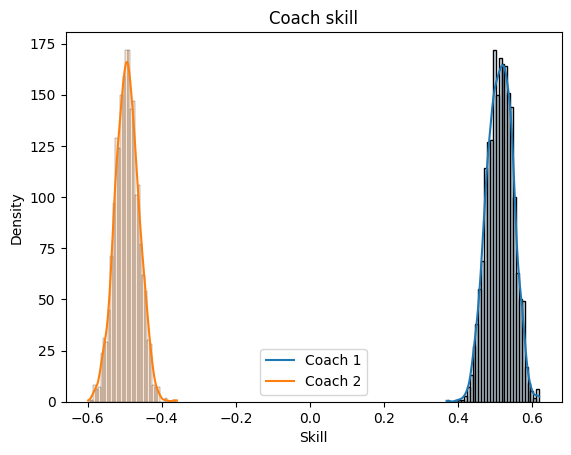

In [5]:
labels = []
for i in range(num_coaches):
    sns.histplot(samples["coach_skills"].detach().squeeze()[:,i], kde=True, alpha=0.2)
    labels.append(f"Coach {i+1}")

plt.legend(labels)
plt.xlabel("Skill")
plt.ylabel("Density")
plt.title("Coach skill")
plt.show()

# Try and make some fake data with multiple players where the player with the higher index always wins.

In [11]:
num_coaches = 6
# assuming round robin
num_games = 15

# round robin structure generated by chatgpt
id1 = [1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 4, 4, 5]
id2 = [2, 3, 4, 5, 6, 3, 4, 5, 6, 4, 5, 6, 5, 6, 6]

id1 = torch.tensor(id1).long()
id1 = id1 - 1
id2 = torch.tensor(id2).long()
id2 = id2 - 1

obs = []
for i in range(num_games):
    if id1[i] < id2[i]:
        obs.append(-1)
    else:
        obs.append(1)

obs = torch.tensor(obs)

game_info = {'coach1_id': id1, 'coach2_id': id2, 'num_coaches': num_coaches}

In [12]:
run_inference(model3, game_info, obs)

Step 0 : loss = 522.6052765846252
Step 100 : loss = 73.43268418312073
Step 200 : loss = 47.21532726287842
Step 300 : loss = 53.08317744731903
Step 400 : loss = 46.24040067195892
Step 500 : loss = 54.87169790267944
Step 600 : loss = 46.543558955192566
Step 700 : loss = 51.665260314941406
Step 800 : loss = 49.995307207107544
Step 900 : loss = 48.809945821762085
Step 1000 : loss = 45.766353130340576
Step 1100 : loss = 46.65969693660736
Step 1200 : loss = 46.24312353134155
Step 1300 : loss = 47.16174364089966
Step 1400 : loss = 53.88247609138489
Step 1500 : loss = 48.62885224819183
Step 1600 : loss = 47.434438705444336
Step 1700 : loss = 50.26277732849121
Step 1800 : loss = 51.32050800323486
Step 1900 : loss = 52.60270071029663
Step 2000 : loss = 45.69535756111145
Step 2100 : loss = 45.0437593460083
Step 2200 : loss = 49.85901951789856
Step 2300 : loss = 45.635923862457275
Step 2400 : loss = 54.59036111831665
Step 2500 : loss = 42.91707515716553
Step 2600 : loss = 46.862597584724426
Step 2

In [13]:
predictive = Predictive(model3, guide=AutoNormal(model3), num_samples=2000)

samples = predictive(game_info, obs)

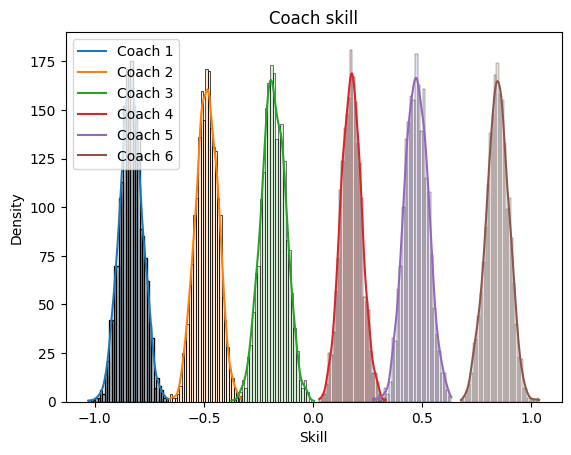

In [14]:
labels = []
for i in range(num_coaches):
    sns.histplot(samples["coach_skills"].detach().squeeze()[:,i], kde=True, alpha=0.2)
    labels.append(f"Coach {i+1}")
    
plt.legend(labels)
plt.xlabel("Skill")
plt.ylabel("Density")
plt.title("Coach skill")
plt.show()


# Try training on real data

In [16]:
# read and format data
df = pd.read_csv('../data/X_train.csv')

# make a list of unique coaches
coaches1 = df['team1_coach_id']
coaches2 = df['team2_coach_id']
unique_coaches = pd.concat([coaches1, coaches2]).unique()
unique_coaches.sort()

num_coaches = len(unique_coaches)

coach_winrates = np.zeros(num_coaches)
coach_num_matches = np.zeros(num_coaches)

for id, coach_id in enumerate(unique_coaches):
    coach1_df = df[df['team1_coach_id'] == coach_id]

    coach_winrates[id] += 0.5 * (coach1_df["team1_win"] == 0).sum()
    coach_winrates[id] += (coach1_df["team1_win"] == 1).sum()

    coach2_df = df[df['team2_coach_id'] == coach_id]
    coach_winrates[id] += 0.5 * (coach1_df["team2_win"] == 0).sum()
    coach_winrates[id] += (coach2_df["team2_win"] == 1).sum()

    coach_winrates[id] = coach_winrates[id] / (len(coach1_df) + len(coach2_df))
    coach_num_matches[id] = len(coach1_df) + len(coach2_df)

indices = np.lexsort((unique_coaches, coach_winrates, coach_num_matches))
# might fuck up when several coaches has the same number of matches.
sorted_coaches = unique_coaches[indices[::-1]]
sorted_winrates = coach_winrates[indices[::-1]]
sorted_num_matches = coach_num_matches[indices[::-1]]

coach_dict = {coach: i for i, coach in enumerate(sorted_coaches)}

# make variables for the model sorted by winrate
id1 = torch.tensor(coaches1.map(coach_dict).values).long()
id2 = torch.tensor(coaches2.map(coach_dict).values).long()

obs = torch.tensor(df['team1_win'].values)

game_info = {'coach1_id': id1, 'coach2_id': id2, 'num_coaches': num_coaches}

In [17]:
run_inference(model3, game_info, obs)

Step 0 : loss = 1941620.087890625
Step 100 : loss = 509372.26416015625
Step 200 : loss = 470356.0378417969
Step 300 : loss = 460518.5910644531
Step 400 : loss = 457187.47119140625
Step 500 : loss = 456618.5129394531
Step 600 : loss = 455582.5185546875
Step 700 : loss = 455516.6428222656
Step 800 : loss = 454638.4353027344
Step 900 : loss = 454316.29345703125
Step 1000 : loss = 454633.9226074219
Step 1100 : loss = 454632.7761230469
Step 1200 : loss = 454719.1220703125
Step 1300 : loss = 454701.0393066406
Step 1400 : loss = 454253.11181640625
Step 1500 : loss = 454670.9865722656
Step 1600 : loss = 454510.3894042969
Step 1700 : loss = 454408.09521484375
Step 1800 : loss = 454514.7619628906
Step 1900 : loss = 454277.1125488281
Step 2000 : loss = 454185.3405761719
Step 2100 : loss = 454612.5163574219
Step 2200 : loss = 454349.40869140625
Step 2300 : loss = 454328.1796875
Step 2400 : loss = 454634.482421875
Step 2500 : loss = 454427.6796875
Step 2600 : loss = 454302.2421875
Step 2700 : loss 

In [18]:
predictive = Predictive(model3, guide=AutoNormal(model3), num_samples=2000)

samples = predictive(game_info, obs)

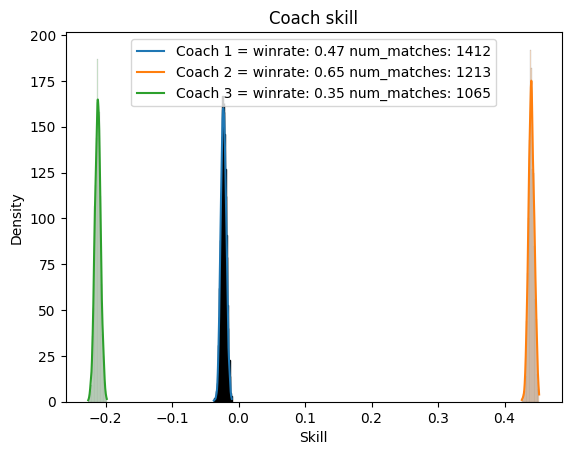

In [21]:
labels = []
for i in range(3):
    sns.histplot(samples["coach_skills"].detach().squeeze()[:,i], kde=True, alpha=0.2)
    labels.append(f"Coach {i+1} = winrate: {sorted_winrates[i]:.2f} num_matches: {int(sorted_num_matches[i])}")
    
plt.legend(labels)
plt.xlabel("Skill")
plt.ylabel("Density")
plt.title("Coach skill")
plt.show()


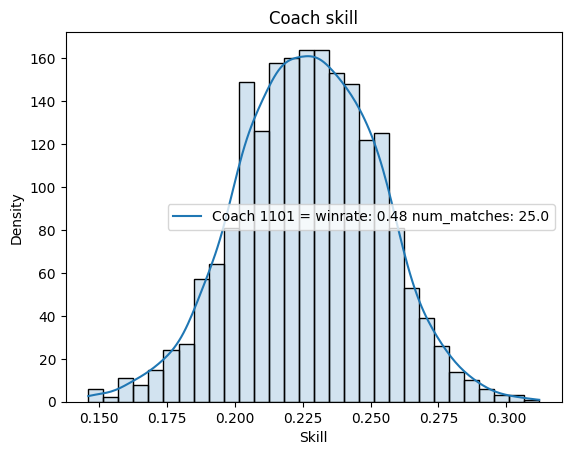

In [22]:
labels = []
for i in range(1100,1101):
    sns.histplot(samples["coach_skills"].detach().squeeze()[:,i], kde=True, alpha=0.2)
    labels.append(f"Coach {i+1} = winrate: {sorted_winrates[i]:.2f} num_matches: {sorted_num_matches[i]}")
    
plt.legend(labels)
plt.xlabel("Skill")
plt.ylabel("Density")
plt.title("Coach skill")
plt.show()


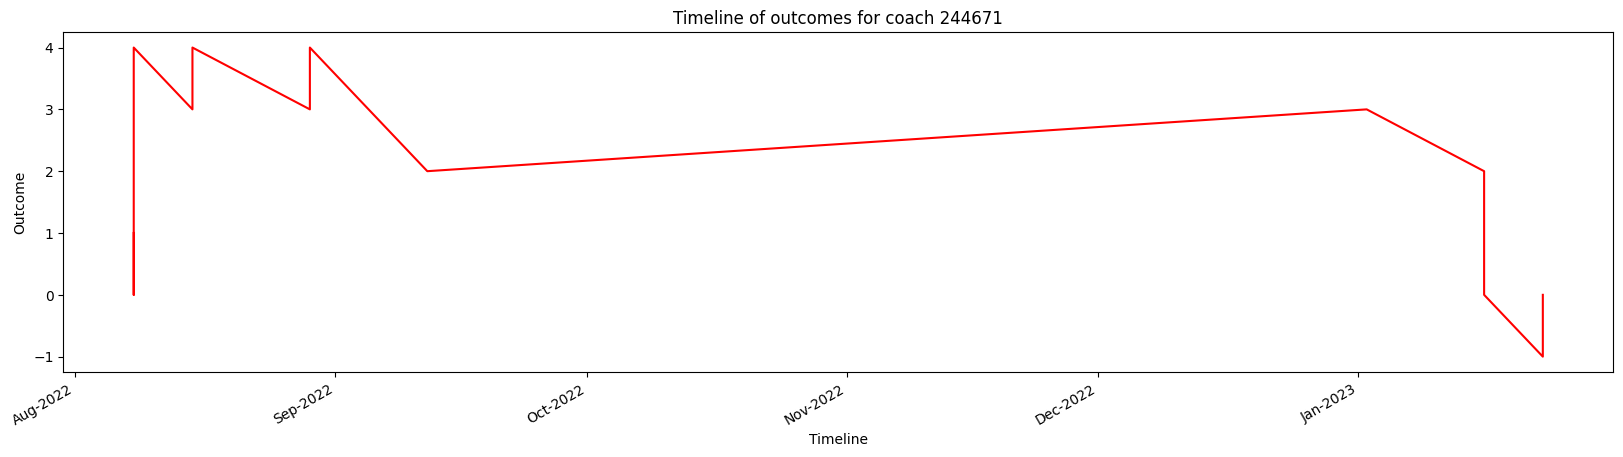

In [23]:
import matplotlib.dates as mdates

df = pd.read_csv('../data/X_train.csv')

# code for plotting the timeline of a coach
coach_index = 1100
coach_id = sorted_coaches[coach_index]

mask = df['team2_coach_id'] == coach_id
df.loc[mask, 'team2_win'] *= -1
df.loc[mask, 'team1_win'] *= -1

coach1_df = df[df['team1_coach_id'] == coach_id].copy()
coach2_df = df[df['team2_coach_id'] == coach_id].copy()

coach_df = pd.concat([coach1_df, coach2_df])
coach_df['week_date'] = pd.to_datetime(coach_df['week_date'])
coach_df = coach_df.sort_values(by='week_date')

# plot the timeline of outcomes for the given coach
plt.figure(figsize=(20, 5))
plt.plot(coach_df['week_date'], np.cumsum(coach_df['team1_win']), 'r')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))  # 'Month-Year' format
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # set locator to month
plt.gcf().autofmt_xdate()  # autoformat the x-axis date
plt.xlabel("Timeline")
plt.ylabel("Outcome")
plt.title(f"Timeline of outcomes for coach {coach_id}")
plt.show()
